In [ ]:
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

In [ ]:
!unzip mnist.zip
print('listo')

Streaming output truncated to the last 5000 lines.
  inflating: mnist/train/5/2207.png  
  inflating: mnist/train/5/2214.png  
  inflating: mnist/train/5/2224.png  
  inflating: mnist/train/5/2237.png  
  inflating: mnist/train/5/2241.png  
  inflating: mnist/train/5/2247.png  
  inflating: mnist/train/5/2279.png  
  inflating: mnist/train/5/2282.png  
  inflating: mnist/train/5/2291.png  
  inflating: mnist/train/5/2322.png  
  inflating: mnist/train/5/2339.png  
  inflating: mnist/train/5/2346.png  
  inflating: mnist/train/5/2369.png  
  inflating: mnist/train/5/2400.png  
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  

In [ ]:
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [ ]:
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [ ]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [ ]:
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [ ]:
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [ ]:
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [ ]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()
  

In [ ]:
def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)

# Pimera parte
##Primera red nueronal


*   batch_size=256
*   Epoch = 40
*   weight_decay = 0.001
*   learning_rate = 0.001



In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 256

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [ ]:
input_dim = 28*28
out_dim = 10
hidden = 50
learning_rate = 0.001
weight_decay = 0.001

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
n_epoch = 40

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

total_it = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()

    Xtr = X_train_batch.view(X_train_batch.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_batch,Y_pred, average='macro') )
  
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    total_it += 1

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch, loss_train[-1], f1_train[-1], acc_train[-1]) )

Epoch [1/40], loss: 2.218693971633911. f1:0.2284632404592397 acc: 0.3227272629737854 
Epoch [2/40], loss: 2.0689260959625244. f1:0.47159019687566267 acc: 0.5375000238418579 
Epoch [3/40], loss: 1.9124075174331665. f1:0.5572546916131792 acc: 0.6090909242630005 
Epoch [4/40], loss: 1.6750638484954834. f1:0.6441515367311541 acc: 0.6670454740524292 
Epoch [5/40], loss: 1.4065786600112915. f1:0.7365866289702194 acc: 0.7477272748947144 
Epoch [6/40], loss: 1.2016667127609253. f1:0.7675735860441419 acc: 0.7670454382896423 
Epoch [7/40], loss: 0.9347144365310669. f1:0.8276559359153689 acc: 0.8261363506317139 
Epoch [8/40], loss: 0.7587668895721436. f1:0.8364800255937365 acc: 0.8374999761581421 
Epoch [9/40], loss: 0.6415347456932068. f1:0.8111233213929525 acc: 0.8136363625526428 
Epoch [10/40], loss: 0.5342634320259094. f1:0.8690115771363173 acc: 0.8681818246841431 
Epoch [11/40], loss: 0.47909390926361084. f1:0.8776286267434511 acc: 0.8795454502105713 
Epoch [12/40], loss: 0.4378678500652313.

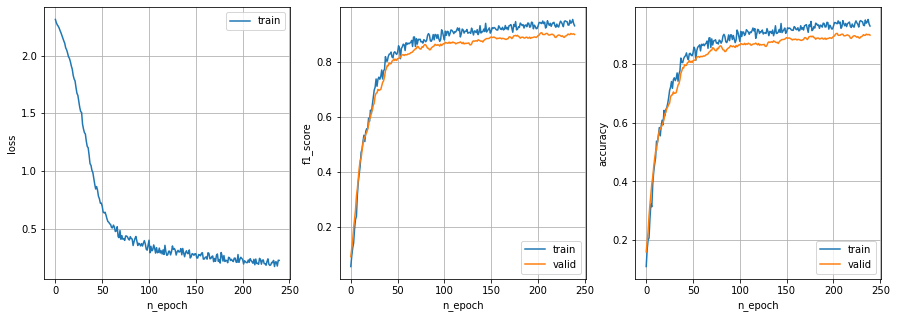

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(total_it), loss_train, label='train')
# plt.plot(range(total_it), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(total_it), f1_train, label='train')
plt.plot(range(total_it), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(total_it), acc_train, label='train')
plt.plot(range(total_it), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [ ]:
#-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.2991979420185089, f1: 0.9107193295245741, acc: 0.9112903475761414


##Primnera red nueronal


*   batch_size=128
*   Epoch = 80
*   weight_decay = 0.02
*   learning_rate = 0.0001


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 128

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [ ]:
input_dim = 28*28
out_dim = 10
hidden = 50
learning_rate = 0.0001
weight_decay = 0.02

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
n_epoch = 80

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

total_it = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()

    Xtr = X_train_batch.view(X_train_batch.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_batch,Y_pred, average='macro') )
  
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    total_it += 1

  #print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch, loss_train[-1], f1_train[-1], acc_train[-1]) )

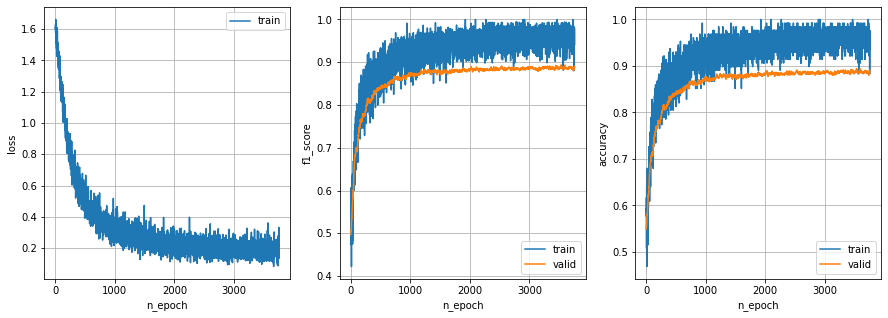

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(total_it), loss_train, label='train')
# plt.plot(range(total_it), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(total_it), f1_train, label='train')
plt.plot(range(total_it), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(total_it), acc_train, label='train')
plt.plot(range(total_it), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [ ]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3237740695476532, f1: 0.912520673377046, acc: 0.913306474685669


# Segunda parte

Esta claro que el primer modelo tuvo un mejor resultado. Ya que en loss, f1 y acc desempeño mejor.

Con estos paremtros obtuve mejores resultados
*   batch_size=256
*   Epoch = 40
*   weight_decay = 0.001
*   learning_rate = 0.001

De los dos modelos podemos ver que el segundo empieza a "saltar mucho" entre valores debido el weight_decay tan alto que tiene.<br/>
Para el primer modelo los scores fueron los siguientes. <br/> 
* loss: 0.2991979420185089, f1: 0.9107193295245741, acc: 0.9112903475761414.<br/>

Para el segundo modelo fueron los siguientes <br/>
* loss: 0.3237740695476532, f1: 0.912520673377046, acc: 0.913306474685669 <br/>



  0%|          | 0/32 [00:00<?, ?it/s]

ne: 40, hd:50, wd:0.001, lr: 0.001, bs:128 
Valid Evaluation loss: 0.7648363709449768. f1:0.802417831846736 acc: 0.8029999732971191 


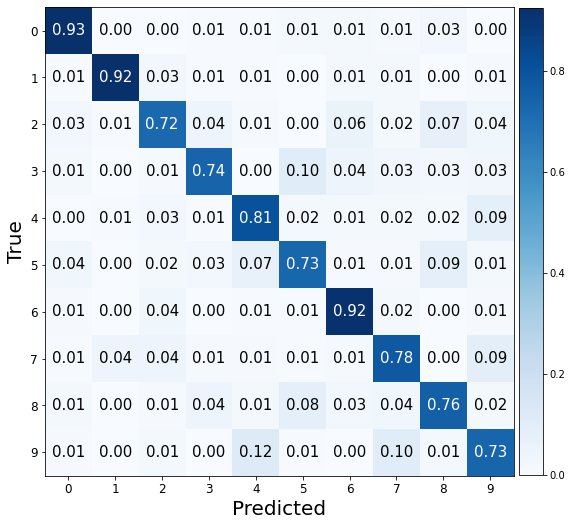

###################

ne: 40, hd:50, wd:0.001, lr: 0.001, bs:128 
Valid Evaluation loss: 0.9215299487113953. f1:0.8239066219000654 acc: 0.8240000009536743 


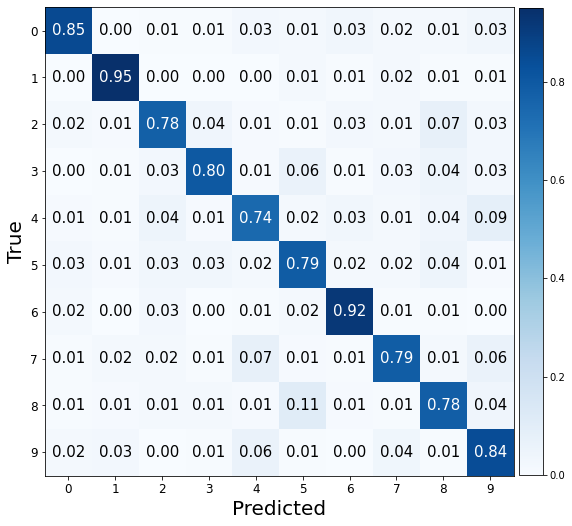

###################

ne: 40, hd:50, wd:0.02, lr: 0.001, bs:128 
Valid Evaluation loss: 1.0319392681121826. f1:0.7551392251841877 acc: 0.7559999823570251 


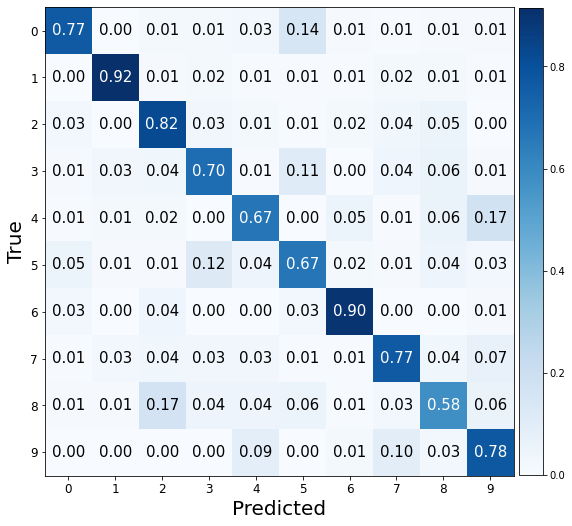

###################

ne: 40, hd:50, wd:0.02, lr: 0.001, bs:128 
Valid Evaluation loss: 0.8723304271697998. f1:0.7983015535137886 acc: 0.7979999780654907 


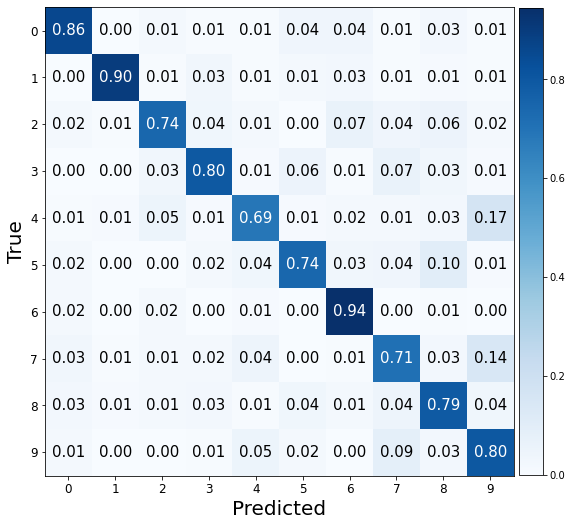

###################

ne: 40, hd:50, wd:0.001, lr: 0.0001, bs:128 
Valid Evaluation loss: 4.476670265197754. f1:0.5235117930794073 acc: 0.5254999995231628 


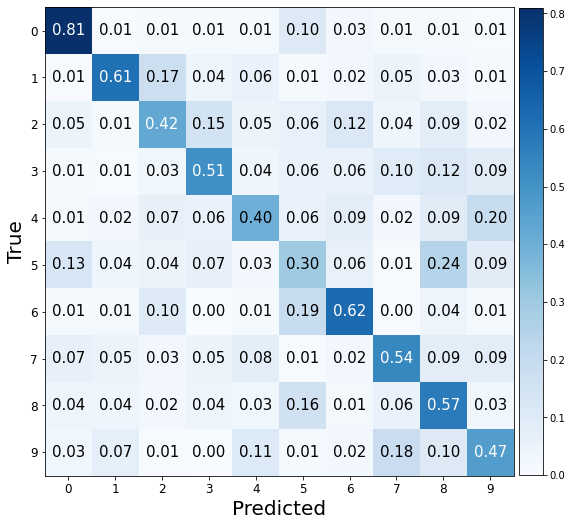

###################

ne: 40, hd:50, wd:0.001, lr: 0.0001, bs:128 
Valid Evaluation loss: 4.728543758392334. f1:0.5120238968198624 acc: 0.515500009059906 


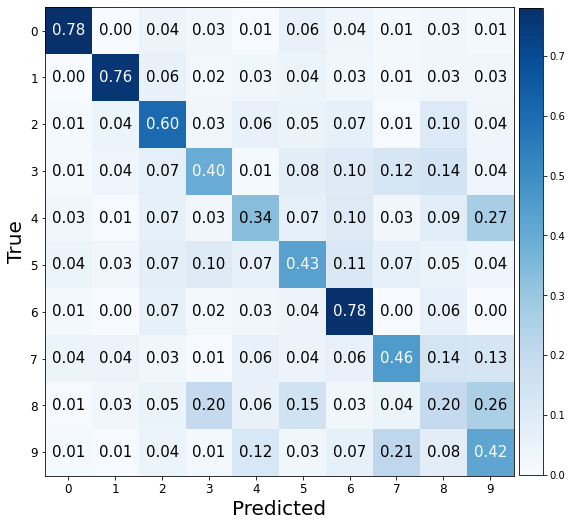

###################

ne: 40, hd:50, wd:0.02, lr: 0.0001, bs:128 
Valid Evaluation loss: 5.566843032836914. f1:0.4870608000077376 acc: 0.4880000054836273 


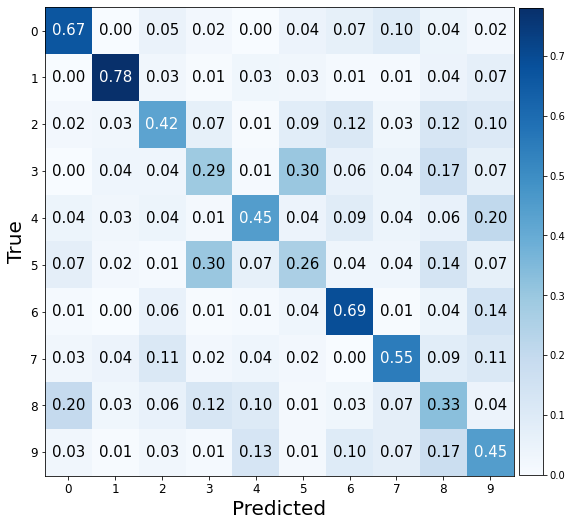

###################

ne: 40, hd:50, wd:0.02, lr: 0.0001, bs:128 
Valid Evaluation loss: 4.895196914672852. f1:0.5230624807445851 acc: 0.5214999914169312 


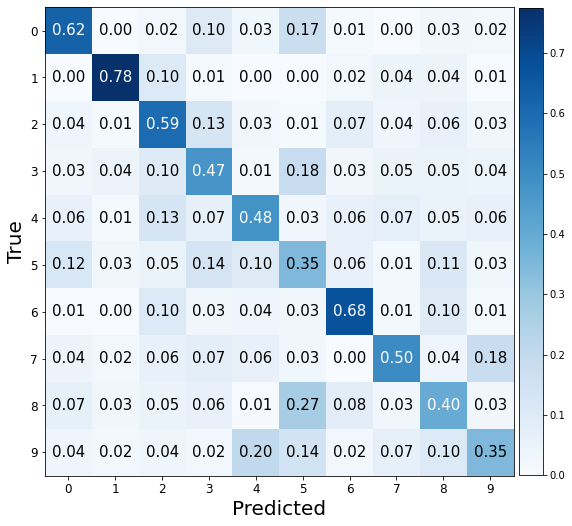

###################

ne: 40, hd:50, wd:0.001, lr: 0.001, bs:265 
Valid Evaluation loss: 0.9523472785949707. f1:0.7998393892023876 acc: 0.800000011920929 


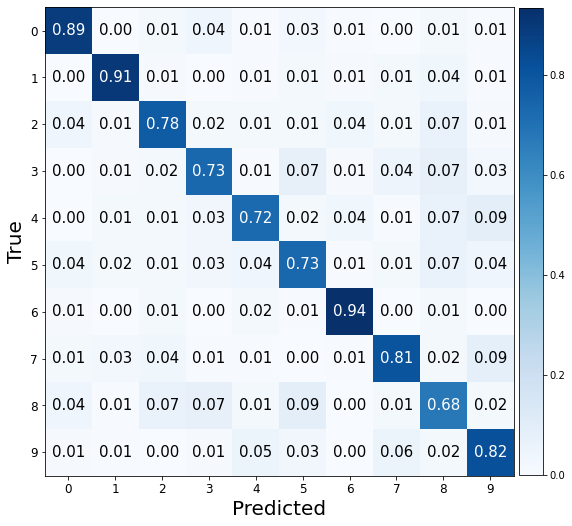

###################

ne: 40, hd:50, wd:0.001, lr: 0.001, bs:265 
Valid Evaluation loss: 0.7114009261131287. f1:0.8415562905806446 acc: 0.8414999842643738 


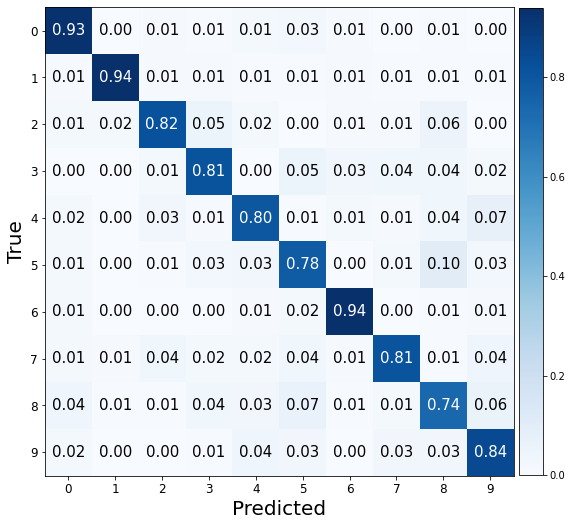

###################

ne: 40, hd:50, wd:0.02, lr: 0.001, bs:265 
Valid Evaluation loss: 1.0400571823120117. f1:0.7954754563767992 acc: 0.7944999933242798 


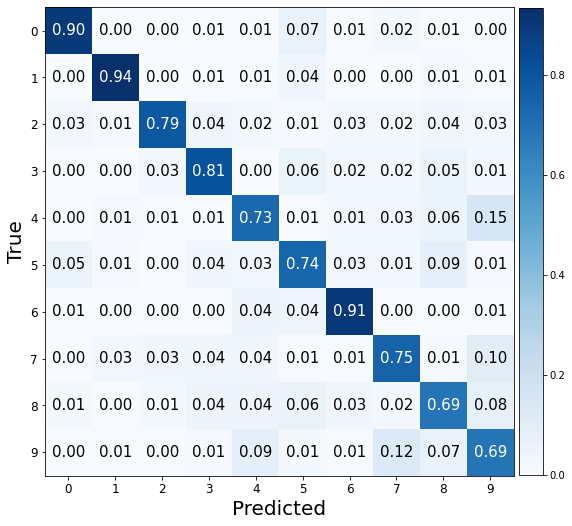

###################

ne: 40, hd:50, wd:0.02, lr: 0.001, bs:265 
Valid Evaluation loss: 0.936890721321106. f1:0.7823315589151185 acc: 0.781000018119812 


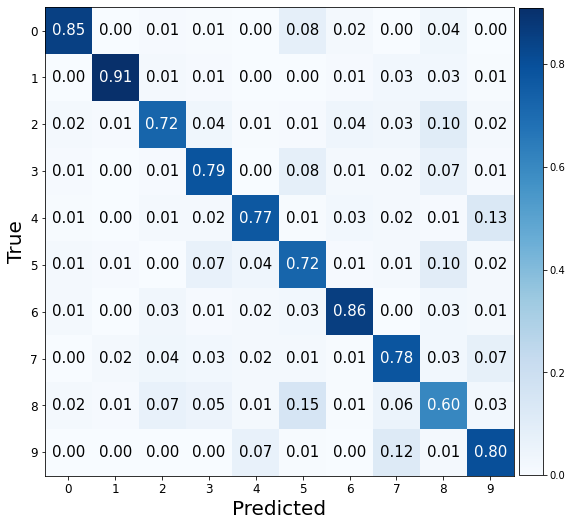

###################

ne: 40, hd:50, wd:0.001, lr: 0.0001, bs:265 
Valid Evaluation loss: 4.195669174194336. f1:0.5207281024227198 acc: 0.5270000100135803 


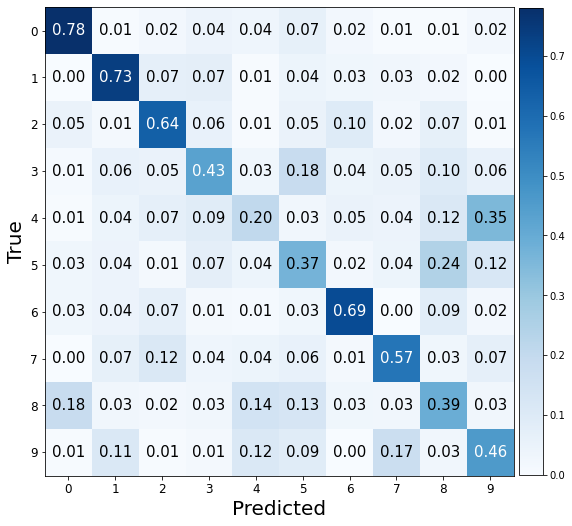

###################

ne: 40, hd:50, wd:0.001, lr: 0.0001, bs:265 
Valid Evaluation loss: 4.816227912902832. f1:0.5207512929542011 acc: 0.5245000123977661 


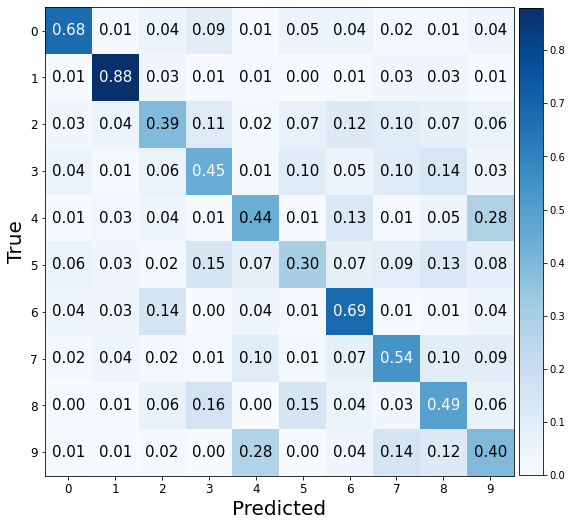

###################

ne: 40, hd:50, wd:0.02, lr: 0.0001, bs:265 
Valid Evaluation loss: 3.3124001026153564. f1:0.5592476157653513 acc: 0.5609999895095825 


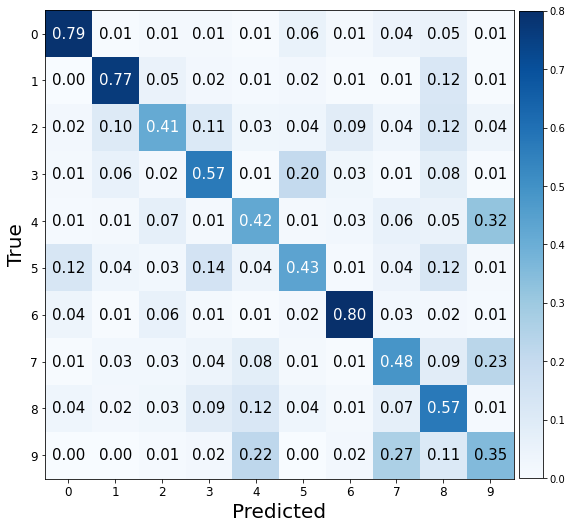

###################

ne: 40, hd:50, wd:0.02, lr: 0.0001, bs:265 
Valid Evaluation loss: 5.052270889282227. f1:0.41253974536610444 acc: 0.414000004529953 


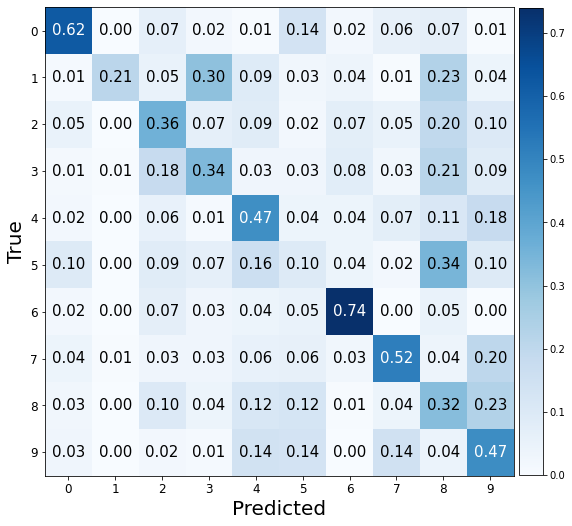

###################

ne: 80, hd:50, wd:0.001, lr: 0.001, bs:128 
Valid Evaluation loss: 0.6338302493095398. f1:0.8610701535290317 acc: 0.8615000247955322 


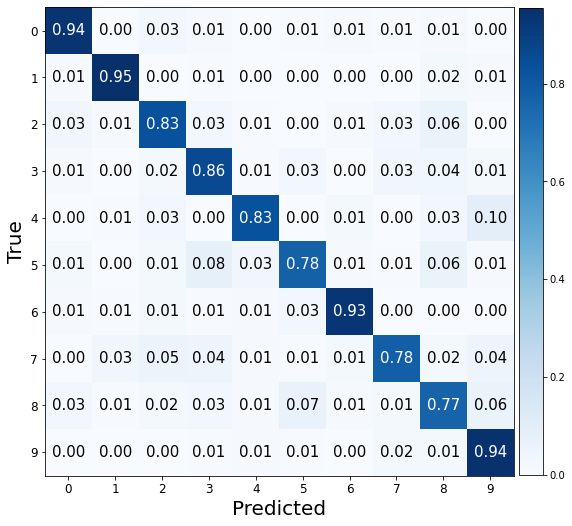

###################

ne: 80, hd:50, wd:0.001, lr: 0.001, bs:128 
Valid Evaluation loss: 0.8067129850387573. f1:0.815771340365273 acc: 0.8165000081062317 


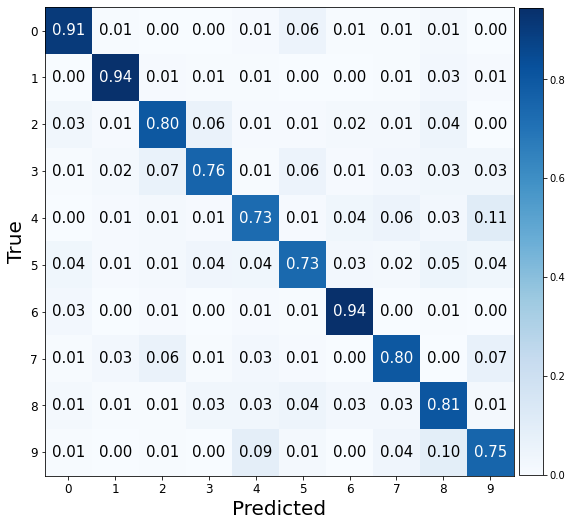

###################

ne: 80, hd:50, wd:0.02, lr: 0.001, bs:128 
Valid Evaluation loss: 0.7424570918083191. f1:0.8463083042246303 acc: 0.8475000262260437 


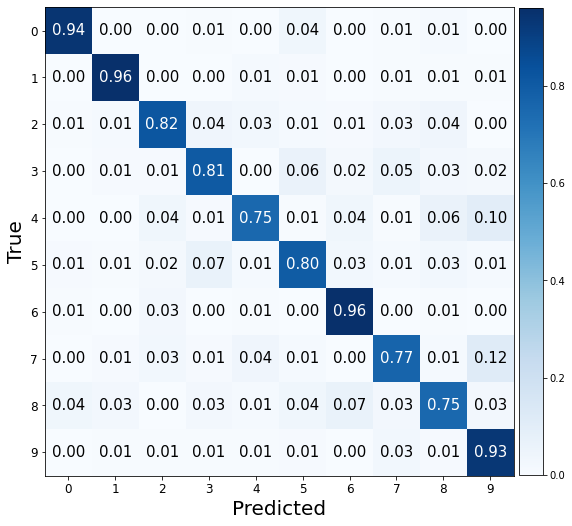

###################

ne: 80, hd:50, wd:0.02, lr: 0.001, bs:128 
Valid Evaluation loss: 0.6896981596946716. f1:0.8531380382177586 acc: 0.8535000085830688 


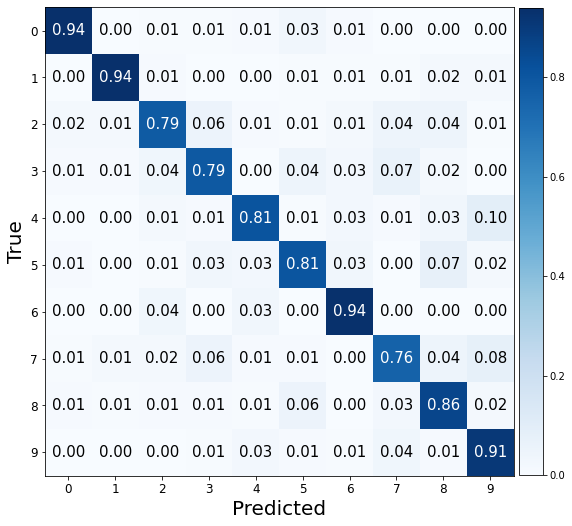

###################

ne: 80, hd:50, wd:0.001, lr: 0.0001, bs:128 
Valid Evaluation loss: 2.858635187149048. f1:0.6109492844938296 acc: 0.612500011920929 


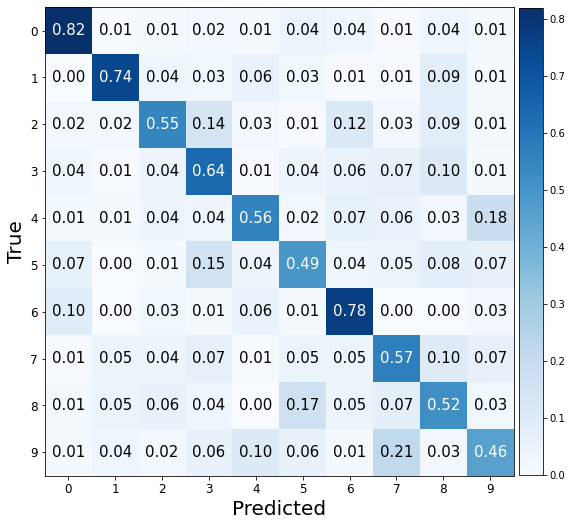

###################

ne: 80, hd:50, wd:0.001, lr: 0.0001, bs:128 
Valid Evaluation loss: 2.524977207183838. f1:0.6948889481838789 acc: 0.6959999799728394 


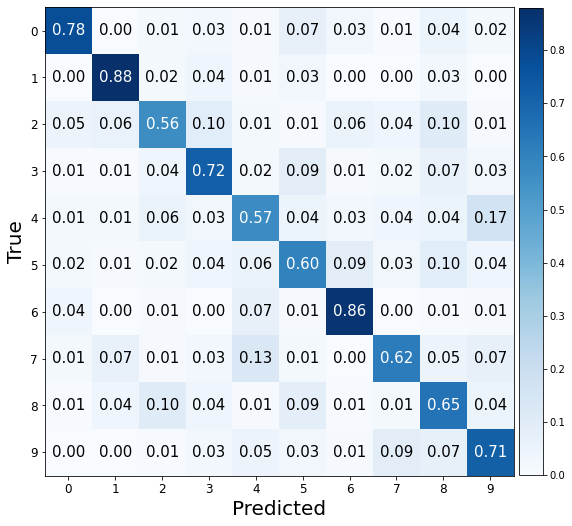

###################

ne: 80, hd:50, wd:0.02, lr: 0.0001, bs:128 
Valid Evaluation loss: 2.886765718460083. f1:0.6540432201673996 acc: 0.6549999713897705 


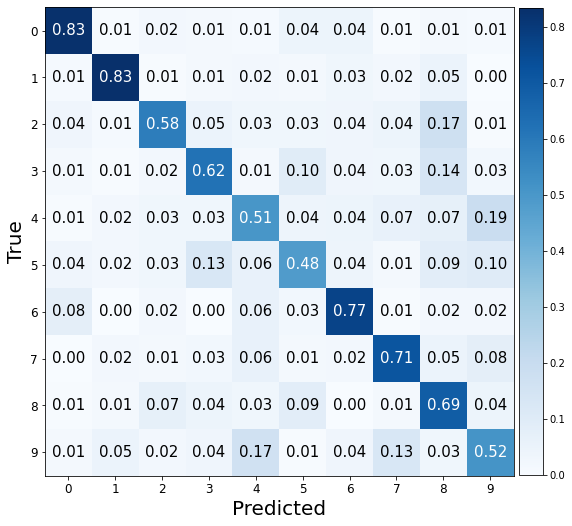

###################

ne: 80, hd:50, wd:0.02, lr: 0.0001, bs:128 
Valid Evaluation loss: 2.5198380947113037. f1:0.6739145368375612 acc: 0.6759999990463257 


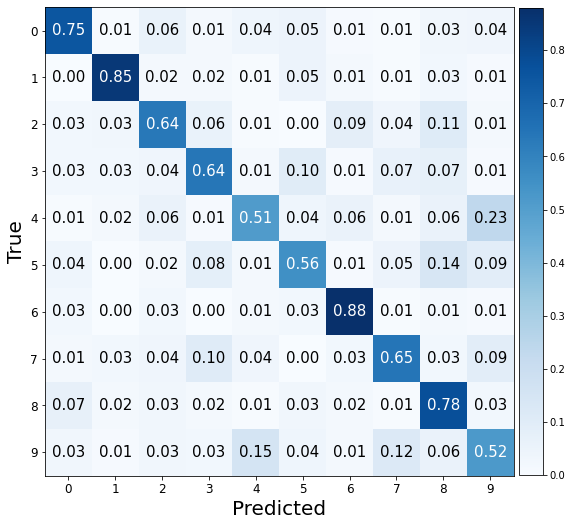

###################

ne: 80, hd:50, wd:0.001, lr: 0.001, bs:265 
Valid Evaluation loss: 0.7349926829338074. f1:0.8171366032003036 acc: 0.8174999952316284 


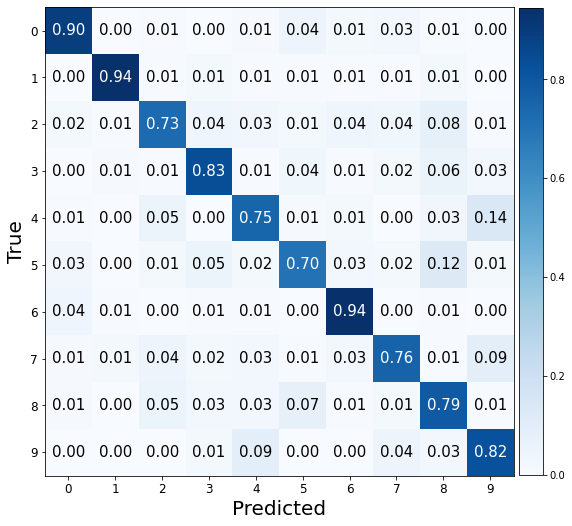

###################

ne: 80, hd:50, wd:0.001, lr: 0.001, bs:265 
Valid Evaluation loss: 0.7630157470703125. f1:0.8563473045433476 acc: 0.8569999933242798 


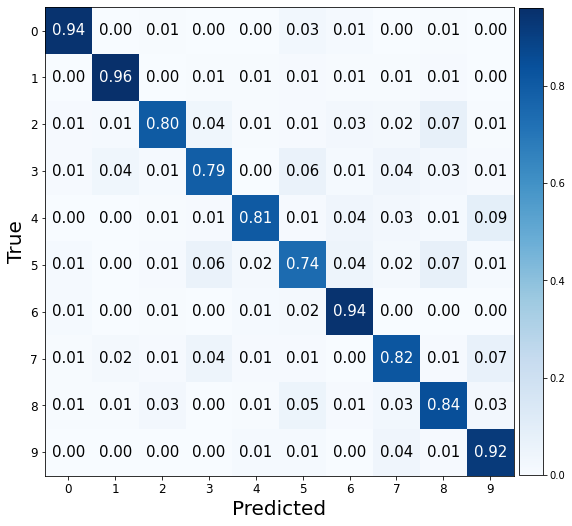

###################

ne: 80, hd:50, wd:0.02, lr: 0.001, bs:265 
Valid Evaluation loss: 0.7228328585624695. f1:0.8310503233446684 acc: 0.8309999704360962 


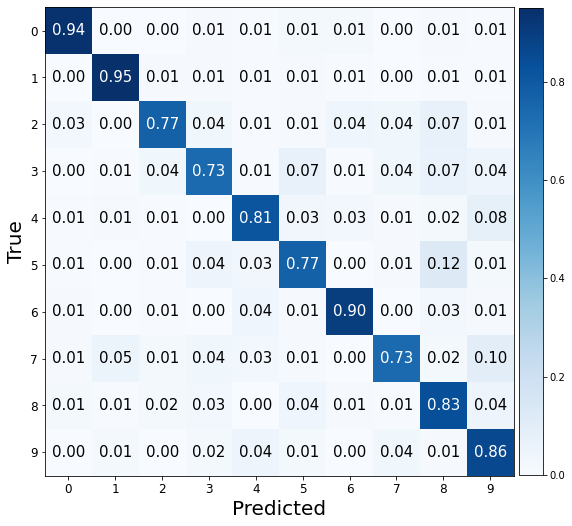

###################

ne: 80, hd:50, wd:0.02, lr: 0.001, bs:265 
Valid Evaluation loss: 0.7654051780700684. f1:0.8396133340957392 acc: 0.8399999737739563 


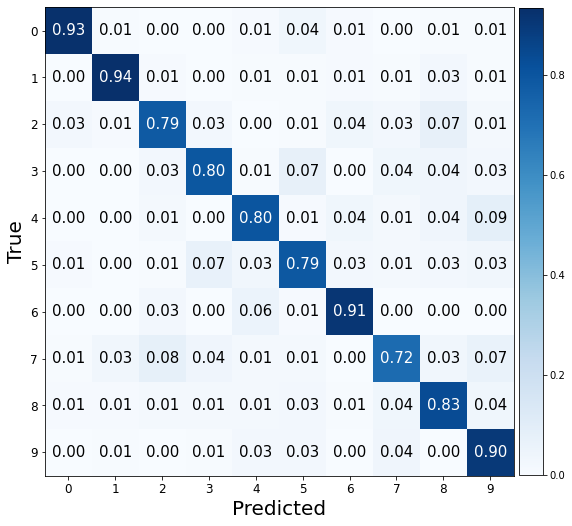

###################

ne: 80, hd:50, wd:0.001, lr: 0.0001, bs:265 
Valid Evaluation loss: 2.1523871421813965. f1:0.6911925811332926 acc: 0.6930000185966492 


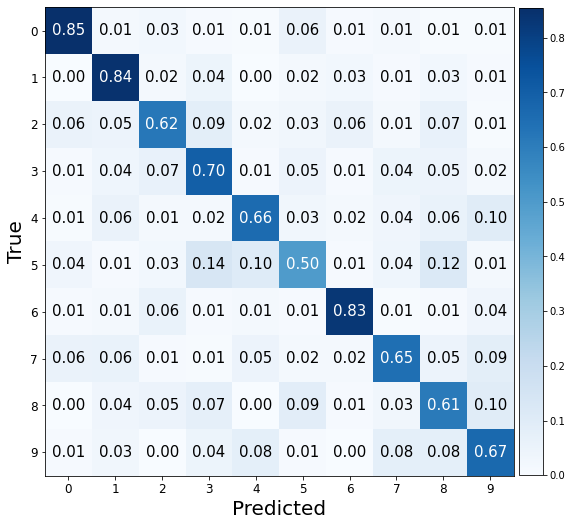

###################

ne: 80, hd:50, wd:0.001, lr: 0.0001, bs:265 
Valid Evaluation loss: 3.0624096393585205. f1:0.6976460190384379 acc: 0.6980000138282776 


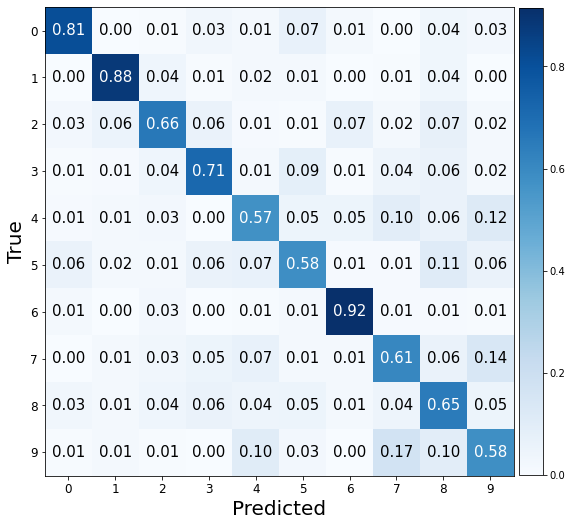

###################

ne: 80, hd:50, wd:0.02, lr: 0.0001, bs:265 
Valid Evaluation loss: 2.2014272212982178. f1:0.6964137381874939 acc: 0.6965000033378601 


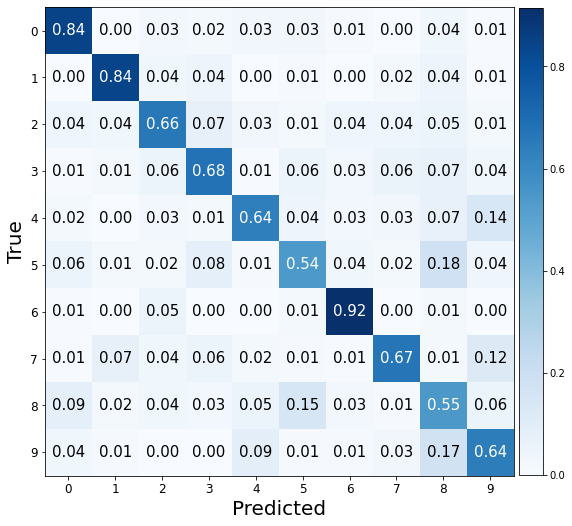

###################

ne: 80, hd:50, wd:0.02, lr: 0.0001, bs:265 
Valid Evaluation loss: 2.6555912494659424. f1:0.624023787947413 acc: 0.6234999895095825 


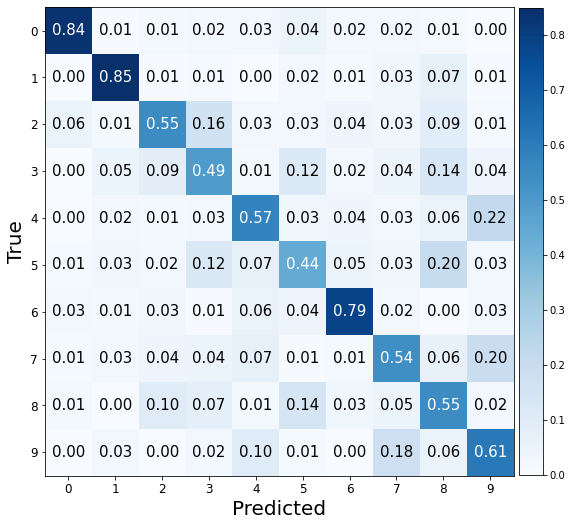

###################



In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [128,265]
lr_list = [0.001,0.0001]
wd_list = [0.001,0.02]
hd_list = [50,50]
ne_list = [40,80]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          train_valid(model,ne,optimizer,criterion)
          print('###################\n')

          pbar.update()
pbar.close()